# Exploring the data

Let's do some simple exploration of the raw data.

The sample used for the example is the red channel data of the NGC 5907 observation.

## Check the structure

In [1]:
from astropy.io import fits

path = 'data/SOFIA/FIFI-LS/OC6U/20190302_F551/raw/r3/data/si/Folder4/Data/'
infile = '00464_091322_00001_ngc_5907_act1_0_0_A_lw.fits'
with fits.open(path+infile) as hdul:
    hdul.info()
    header = hdul['PRIMARY'].header

Filename: data/SOFIA/FIFI-LS/OC6U/20190302_F551/raw/r3/data/si/Folder4/Data/00464_091322_00001_ngc_5907_act1_0_0_A_lw.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     210   ()      
  1  FIFILS_rawdata    1 BinTableHDU     16   7680R x 2C   [8I, 468I]   


## Check if the observed precipitated water vapor has been added to the header

New observations contain this value.

For old observations, we are adding these values and the process is currently in progress.

In [2]:
try:
    print('Observed water vapor is there:', header['WVZ_OBS'])
except:
    print('No observed water vapor present in the header')

Observed water vapor is there: 2.6


## Check some parameters

We can see a few important parameters from the header: 

- altitude (barometric altitude of the plane)

- elevation (or zenithal angle)
 
- observed precipitated water vapor (at the zenith) 

### Important things to check

Some files are corrupted or with bad data.
It is important to discard them before running the reduction.
These are the two most important cases:

- Corrupted files: they usually have a smaller size

- Zenithal angles lower than 32$^o$ or greater than 67$^o$ generate vignetting in the image. In fact, the telescope intercepts the SOFIA door !

Corrupted files: 
00556_101218_00004_ngc_5907_act1s_-4_9_A_lw.fits
00563_101706_00005_ngc_5907_act1s_23_22_A_lw.fits


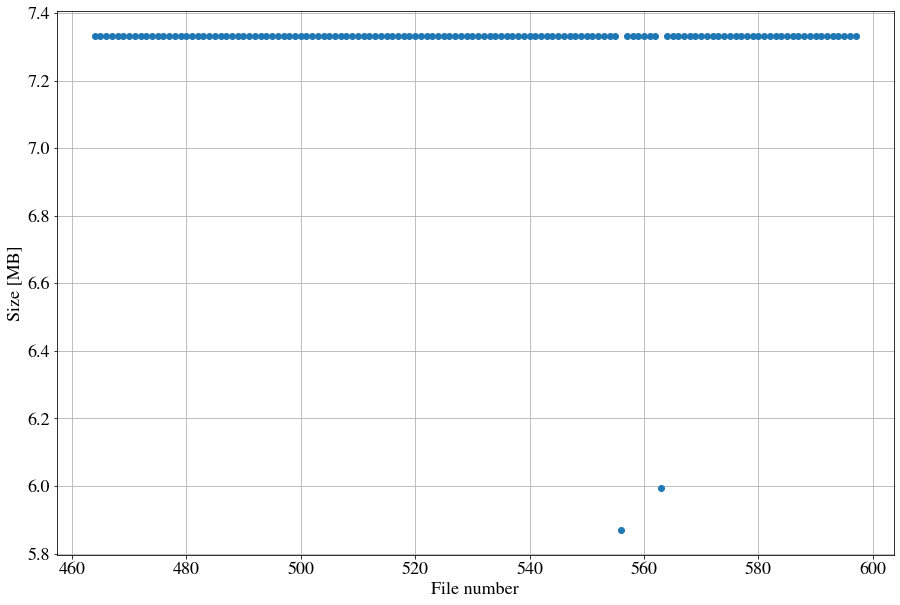

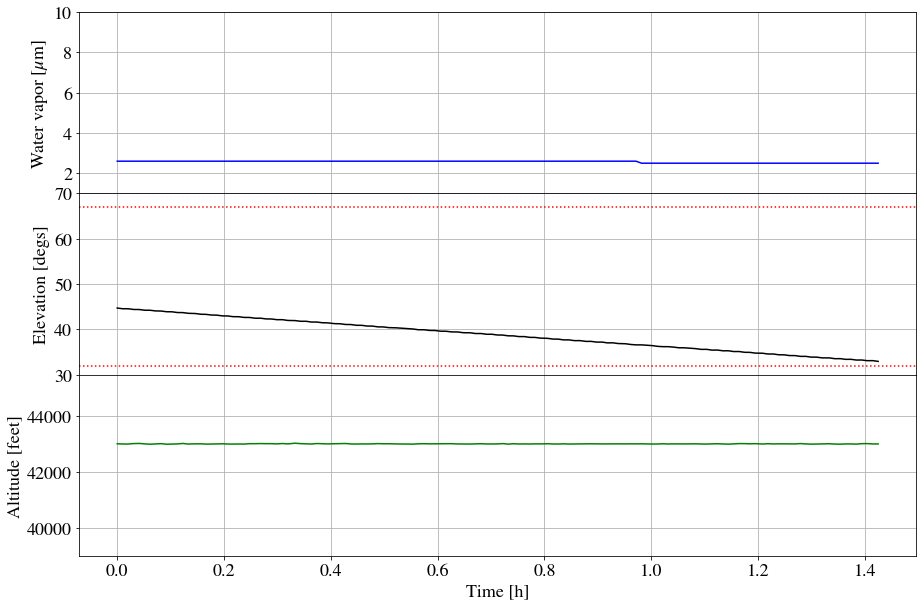

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family']='STIXGeneral'
rcParams['font.size']=18
rcParams['mathtext.fontset']='stix'
rcParams['legend.numpoints']=1
from astropy.io import fits
from glob import glob
import numpy as np
from astropy.time import Time
import os

path = 'data/SOFIA/FIFI-LS/OC6U/20190302_F551/raw/r3/data/si/Folder4/Data/'
files = sorted(glob(path + '*lw.fits'), key=os.path.getctime)
files = np.array(files)
altitude = []
wvz = []
elevation = []
time = []
latitude = []
longitude = []
file_size=[]

numfile = [os.path.basename(x)[0:5] for x in files]

for file in files:
    fsize = os.stat(file)
    file_size.append(fsize.st_size)
    with fits.open(file) as hdul:
        h = hdul['PRIMARY'].header
        altitude.append(h['ALTI_STA'])
        wvz.append(h['WVZ_OBS'])
        elevation.append(h['ZA_START'])
        unixt = Time(h['DATE-OBS']).unix
        time.append(unixt)
        latitude.append(h['LAT_STA'])
        longitude.append(h['LON_STA'])
        
numfile = np.array(numfile, dtype='int')
file_size = np.array(file_size, dtype='float')

medsize = np.nanmedian(file_size)
idx = file_size < medsize
if np.sum(idx) > 0:
    print('Corrupted files: ')
    for f in files[idx]:
        print(os.path.basename(f))
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(numfile,file_size/1.e6,'o')
ax.set_xlabel('File number')
ax.set_ylabel('Size [MB]')
ax.grid()
plt.show()
        
time = np.array(time)
altitude = np.array(altitude)
elevation = np.array(elevation)
wvz = np.array(wvz)
latitude = np.array(latitude)
longitude = np.array(longitude)

# Order with time
s = np.argsort(time)
altitude = altitude[s]
elevation = elevation[s]
wvz = wvz[s]
time = time[s]
latitude = latitude[s]
longitude = longitude[s]

fig,ax = plt.subplots(nrows=3,figsize=(15,10),sharex=True)
dt = (time-time[0])/3600
ax[0].plot(dt, wvz, color='blue')
ax[1].plot(dt, elevation, color='black')
ax[2].plot(dt, altitude, color='green')
ax[0].set_ylim(1,10)
ax[1].set_ylim(30,70)
ax[1].axhline(32,  color='red', ls=':')
ax[1].axhline(67,  color='red', ls=':')
ax[2].set_ylim(39000,45500)
ax[0].set_ylabel('Water vapor [$\mu$m]')
ax[1].set_ylabel('Elevation [degs]')
ax[2].set_ylabel('Altitude [feet]')
ax[2].set_xlabel('Time [h]')
for i in range(3):
    ax[i].grid()
plt.subplots_adjust( hspace=0)    
plt.show()


## Where the observations were taken ?

The header contains the actual positions of SOFIA when the data were taken.

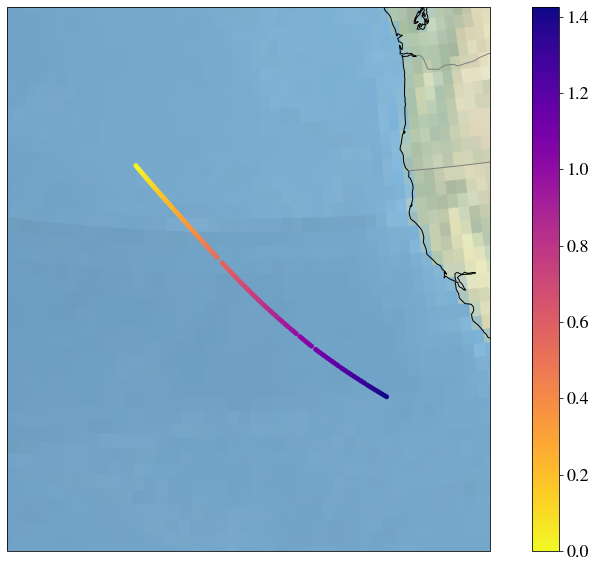

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=[15,10])
clon = np.nanmedian(longitude)
clat = np.nanmedian(latitude)
ax = fig.add_subplot(111, projection = ccrs.Orthographic(central_longitude=clon, central_latitude=clat))
ax.set_extent([clon-10, clon+10, clat-10, clat+10])
ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')

#ax.plot(longitude, latitude,'.',transform=ccrs.PlateCarree())
plt.scatter(longitude, latitude, c=dt, marker='.',cmap='plasma_r', s=100, lw=0, transform=ccrs.PlateCarree())
plt.colorbar()
plt.show()


## How to visualize a ramp

It is challenging to read a raw file, since data are organized in tables.

Each ramp is composed by 32 readouts.

Each file can contain more than one single grating position.

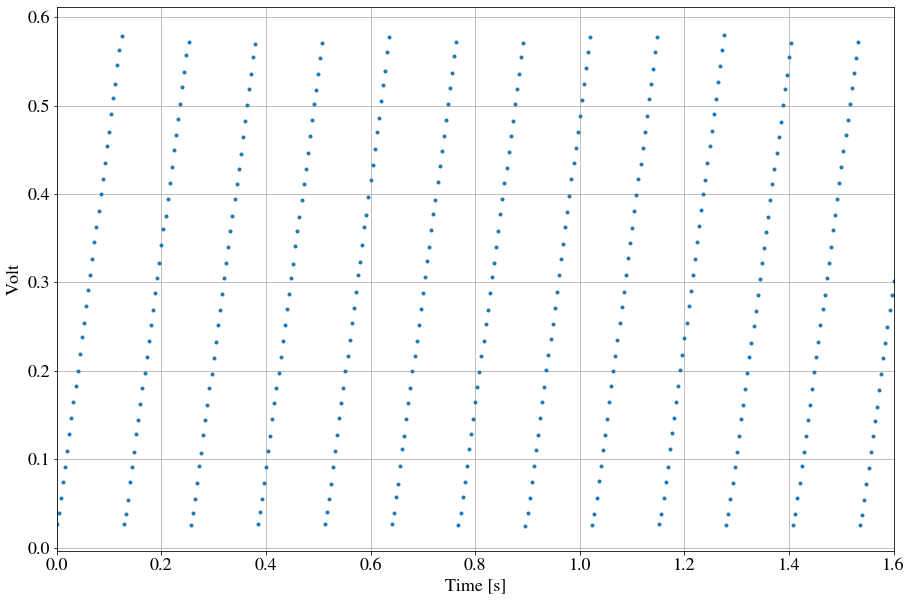

In [9]:
path = 'data/SOFIA/FIFI-LS/OC6U/20190302_F551/raw/r3/data/si/Folder4/Data/'

#infile = '00556_101218_00004_ngc_5907_act1s_-4_9_A_lw.fits'   # Bad file
infile = '00464_091322_00001_ngc_5907_act1_0_0_A_lw.fits'    # Good file

with fits.open(path+infile) as hdul:
    scidata = hdul['FIFILS_rawdata'].data
    header = hdul['PRIMARY'].header
    
detchan = header['DETCHAN']
dichroic = header['DICHROIC']
if detchan == 'RED':
    ncycles = header['C_CYC_R']
    start = header['G_STRT_R']
    step = header['G_SZUP_R']
    ngrat = header['G_PSUP_R']
    order = 1
else:
    ncycles = header['C_CYC_B']
    start = header['G_STRT_B']
    step = header['G_SZUP_B']
    order = header['G_ORD_B']
    
    
data = scidata.DATA
data = np.float32(data) / 2**16 + 0.5  # signed integer to float
data *= 3.63            # ADU to V

# subtract zero channel
for i in range(1,18):
    data[:,i,:25] -= data[:,0,:25]
    
nreadouts = len(data)
if nreadouts < (ncycles*4*ngrat*32):
    print ("WARNING: Number of ramps does not agree with header for ",infile)
else:
    data = data[:ncycles*4*ngrat*32,1:17,:25]  # Only the pixels 1:17 contain data
    flux = data.reshape(ngrat,ncycles*4*32,16,25)
    gratpos = start+step*np.arange(ngrat)
    # Plot the central pixel 8,12 at the initial grating position
    fig,ax = plt.subplots(figsize=(15,10))
    dtime = 1/250 # 250 Hertz
    t = np.arange(ncycles*4*32) * dtime
    ax.plot(t, flux[0,:,8,12],'.')
    ax.set_xlim(0,400/250)
    ax.set_ylabel('Volt')
    ax.set_xlabel('Time [s]')
    plt.grid()
    plt.show()

## Slopes

The following function helps to compute the difference of readouts in the ramps and plot them as a function of time. The option 'subtract' allows one to subtract the 'on-source' ramps from the 'off-source' ramps.

In [161]:
def difframp(infile, ax, spexel=8, spaxel=12,subtract=False):
    import os
    from astropy.io import fits
    import numpy as np
    with fits.open(infile) as hdul:
        scidata = hdul['FIFILS_rawdata'].data
        header = hdul['PRIMARY'].header
    detchan = header['DETCHAN']
    dichroic = header['DICHROIC']
    utcstart = header['UTCSTART']
    nod = header['NODBEAM']
    if detchan == 'RED':
        ncycles = header['C_CYC_R']
        start = header['G_STRT_R']
        step = header['G_SZUP_R']
        ngrat = header['G_PSUP_R']
        order = 1
    else:
        ncycles = header['C_CYC_B']
        start = header['G_STRT_B']
        step = header['G_SZUP_B']
        order = header['G_ORD_B']

    h,m,s = utcstart.split(':')
    utc = int(h) + int(m)/60+ int(s)/3600
 
    data = scidata.DATA
    data = np.float32(data) / 2**16 + 0.5  # signed integer to float
    data *= 3.63            # ADU to V

    # subtract zero channel
    for i in range(1,18):
        data[:,i,:25] -= data[:,0,:25]

    nreadouts = len(data)
    if nreadouts < (ncycles*4*ngrat*32):
        print ("WARNING: Number of ramps does not agree with header for ",os.path.basename(infile),' time ', utcstart)
    else:
        data = data[:ncycles*4*ngrat*32,1:17,:25]  # Only the pixels 1:17 contain data
        flux = data.reshape(ngrat,ncycles*4*32,16,25)
        gratpos = start+step*np.arange(ngrat)
        # Plot the central pixel 8,12 at the initial grating position
        dtime = 1/250 # 250 Hertz
        t = np.arange(ncycles*4*32) * dtime
        for g in range(ngrat):
            f = flux[g,:,spexel,spaxel]
            df = (f[1:]-f[:-1])/dtime
            df = np.concatenate(([np.nan],df))
            # nan starting points
            idx = np.arange(len(df))
            df[idx[::32]]=np.nan
            df[idx[::32]+1]=np.nan
            tt = (t+g*np.max(t))/3600.+utc
            #ax.plot(tt, df,'.',markersize=3)
            dfr = df.reshape(4*ncycles, 32)
            if g == 0:
                color='red'
            elif g == 1:
                color='blue'
            else:
                color='green'
            t32 = tt[::32]
            df32 = np.nanmean(dfr,axis=1)
            idx = np.arange(len(df32))
            if subtract:
                ax.plot(t32[idx[::4]],df32[idx[::4]]-df32[idx[::4]+2] ,'.',markersize=3,color=color)
                ax.plot(t32[idx[::4]+1],df32[idx[::4]+1]-df32[idx[::4]+3] ,'.',markersize=3,color=color)
            else:
                ax.plot(t32[idx[::4]],df32[idx[::4]] ,'.',markersize=4,color=color)
                ax.plot(t32[idx[::4]+1],df32[idx[::4]+1] ,'.',markersize=4,color=color)
                ax.plot(t32[idx[::4]+2],df32[idx[::4]+2] ,'.',markersize=3,color=color,alpha=0.7)
                ax.plot(t32[idx[::4]+3],df32[idx[::4]+3] ,'.',markersize=3,color=color,alpha=0.7)
                

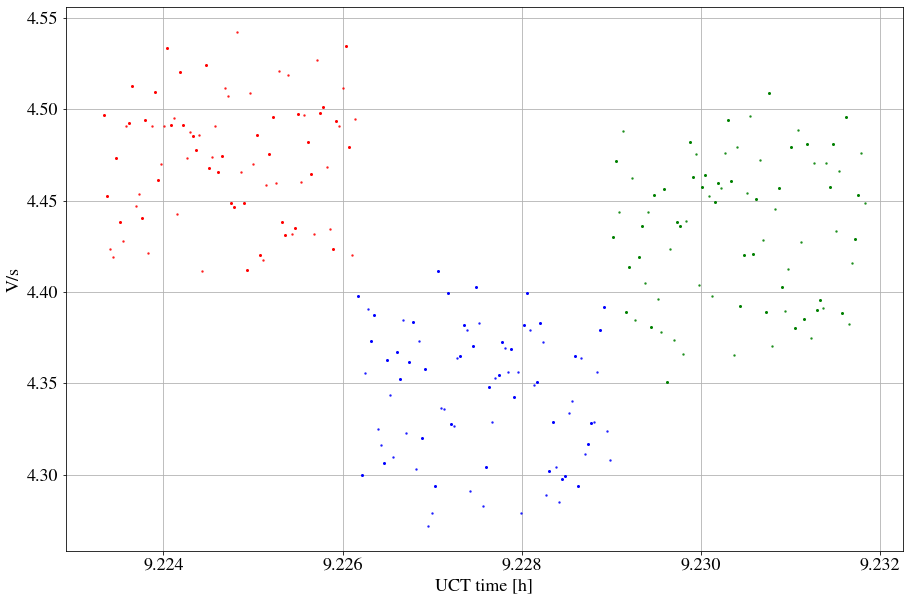

In [162]:
# Differential plot for one file

path = 'data/SOFIA/FIFI-LS/OC6U/20190302_F551/raw/r3/data/si/Folder4/Data/'

#infile = '00556_101218_00004_ngc_5907_act1s_-4_9_A_lw.fits'   # Bad file
infile = '00464_091322_00001_ngc_5907_act1_0_0_A_lw.fits'    # Good file

fig,ax=plt.subplots(figsize=(15,10))
difframp(path+infile,ax)
ax.set_ylabel('V/s')
ax.set_xlabel('UCT time [h]')
ax.grid()
plt.show()


## Slopes as function of time

It is possible to show how ramp slopes change with time.
In this example, the three grating positions corresponding to the pixel(8,14) are shown as a function of time.


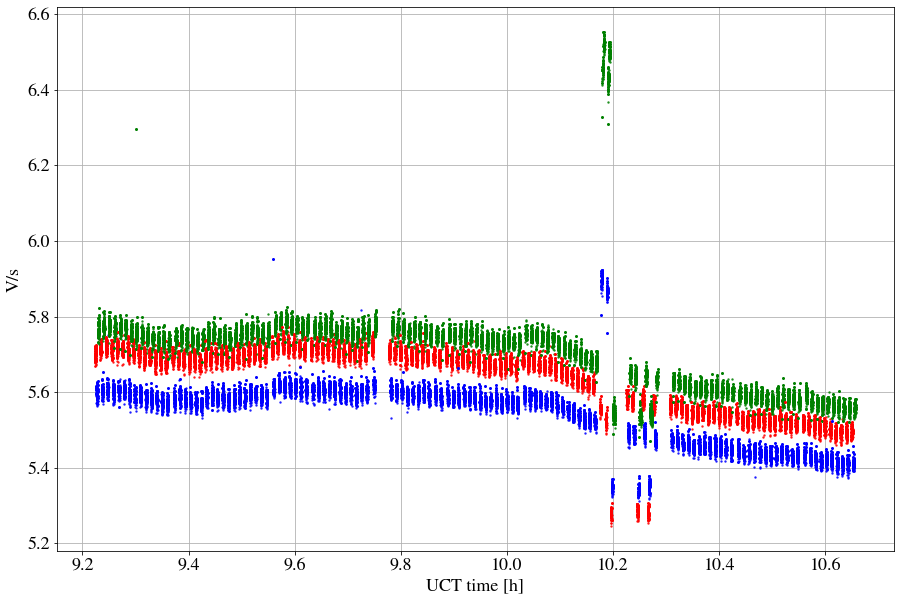

In [163]:
path = 'data/SOFIA/FIFI-LS/OC6U/20190302_F551/raw/r3/data/si/Folder4/Data/'
infiles = sorted(glob(path + '*lw.fits'), key=os.path.getctime)
fig,ax=plt.subplots(figsize=(15,10))
for infile in infiles:
    difframp(infile,ax,spexel=8,spaxel=14)
ax.set_ylabel('V/s')
ax.set_xlabel('UCT time [h]')
ax.grid()
plt.show()


### Subtracting the telescope background
Sudden variations could show potentially noisy data, due to rapid variations of sky conditions.
Most of the time, however, such variations cancel out once the sky position is subtracted from the on-source position, as shown in the next plot.

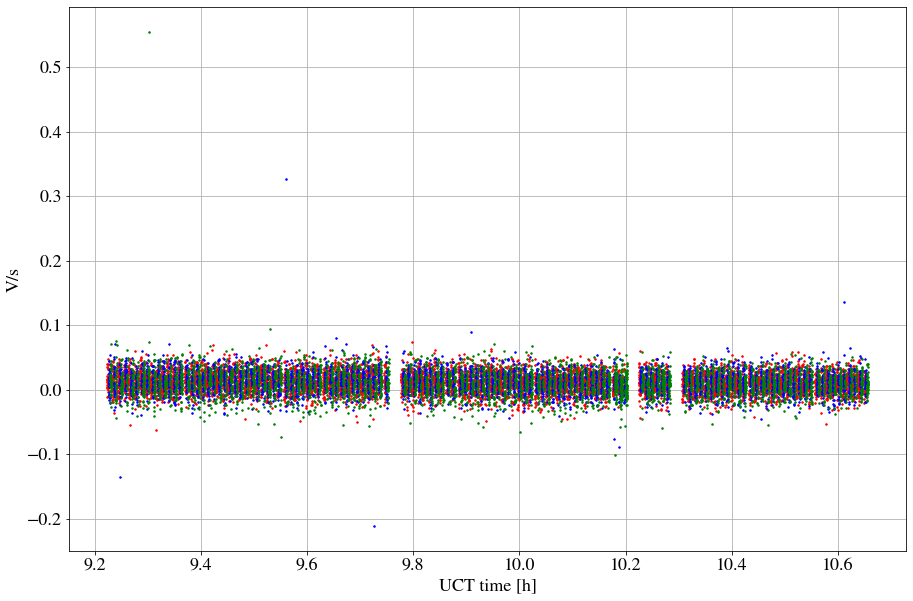

In [164]:
path = 'data/SOFIA/FIFI-LS/OC6U/20190302_F551/raw/r3/data/si/Folder4/Data/'
infiles = sorted(glob(path + '*lw.fits'), key=os.path.getctime)
fig,ax=plt.subplots(figsize=(15,10))
for infile in infiles:
    difframp(infile,ax,spexel=8,spaxel=14,subtract=True)
ax.grid()
ax.set_ylabel('V/s')
ax.set_xlabel('UCT time [h]')
plt.show()
